In [2]:
import optuna
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc
import multiprocessing
import pandas as pd
import optuna.visualization as optvis
%matplotlib inline


from lightgbm import LGBMClassifier, plot_importance
import xgboost as xgb
from xgboost import plot_importance
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from preprocess import data_summary, reduce_mem_usage

# Models
warnings.simplefilter('ignore')
sns.set()


In [3]:
df_train = pd.read_csv('../Data/train_combined.csv')
df_test = pd.read_csv('../Data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)


(590540, 434)
(506691, 433)


In [4]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)


In [5]:
df_train.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
# column details
cat_cols = (['ProductCD'] +
            ['card%d' % i for i in range(1, 7)] +
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] +
            ['M%d' % i for i in range(1, 10)] +
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

id_cols = ['TransactionID', 'TransactionDT']


In [7]:

# Train and test split¶
y_train_ = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()


(590540, 433)
(506691, 433)


4

In [8]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col], X_test[col]])
        dff, _ = pd.factorize(dff, sort=True)
        if dff.max() > 32000:
            print(col, 'needs int32 datatype')

        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')


In [9]:
# Scaling numeric features
cols = X_train.columns
for col in cols:
    if col not in cat_cols and col not in id_cols:
        # min max scalar
        dff = pd.concat([X_train[col], X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1, inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]
del dff


In [10]:
idx_train = X_train.index[:int(X_train.shape[0]*0.75)]
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

x_train, y_train = X_train.iloc[idx_train], y_train_.iloc[idx_train]
x_test, y_test = X_train.iloc[idx_validation], y_train_.iloc[idx_validation]


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(442905, 433)
(147635, 433)
(442905,)
(147635,)


## Base models with standard scaler


In [ ]:
# Put models in a dictionary
models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Random Forest": RandomForestClassifier(),
    "Xgboost": xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)}


# Create function to fit and score models
def fit_and_score_scaled(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    model_classification = {}
    model_roc = {}
    # Loop through models
    for name, model in models.items():
        pipe = make_pipeline(
            StandardScaler(),
            model
        )
        # Fit the model to the data
        pipe.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = pipe.score(X_test, y_test)

        # Make preidctions on test data
        y_preds = pipe.predict(X_test)
        # Show classification report
        model_classification[name] = print(
            classification_report(y_test, y_preds))
        # plot roc curve
        model_roc[name] = plot_roc_curve(pipe, X_test, y_test)

    return model_scores, model_classification, model_roc


              precision    recall  f1-score   support

           0       0.97      0.99      0.98    142535
           1       0.33      0.20      0.25      5100

    accuracy                           0.96    147635
   macro avg       0.65      0.59      0.61    147635
weighted avg       0.95      0.96      0.95    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.82      0.30      0.44      5100

    accuracy                           0.97    147635
   macro avg       0.90      0.65      0.71    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.34      0.48      5100

    accuracy                           0.97    147635
   macro avg       0.89      0.67      0.73    147635
weighted avg       0.97      0.97      0.97    147635



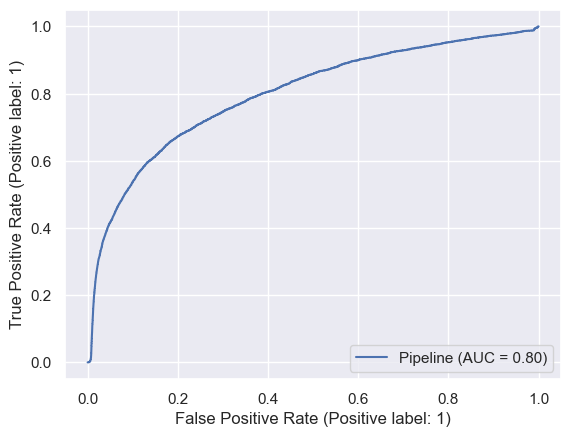

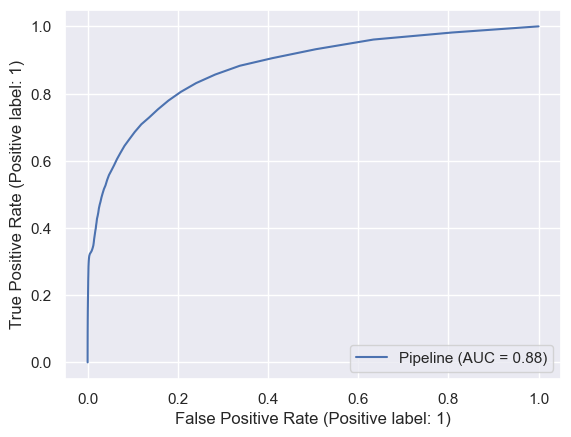

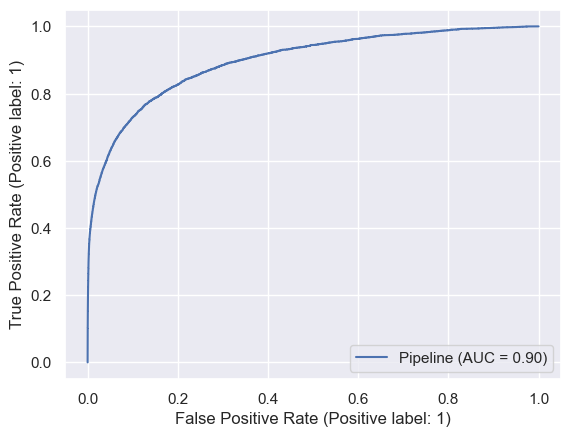

In [ ]:
model_scores = fit_and_score_scaled(models=models,
                                    X_train=x_train,
                                    X_test=x_test,
                                    y_train=y_train,
                                    y_test=y_test)


In [ ]:
model_scores[0]


{'Logistic Regression': 0.9584990009144173,
 'Random Forest': 0.9734412571544688,
 'Xgboost': 0.9743150336979713}

<AxesSubplot: >

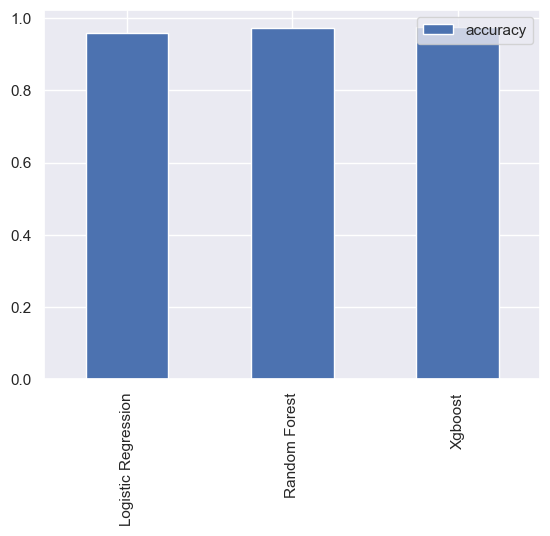

In [ ]:
model_compare = pd.DataFrame(model_scores[0], index=['accuracy'])
model_compare.T.plot.bar()


## base model without standard scaler


In [ ]:
# Create function to fit and score models

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    model_classification = {}
    model_roc = {}
    # Loop through models
    for name, model in models.items():

        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)

        # Make preidctions on test data
        y_preds = model.predict(X_test)
        # Show classification report
        model_classification[name] = print(
            classification_report(y_test, y_preds))
        # plot roc curve
        model_roc[name] = plot_roc_curve(model, X_test, y_test)

    return model_scores, model_classification, model_roc


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142535
           1       0.00      0.00      0.00      5100

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.82      0.30      0.44      5100

    accuracy                           0.97    147635
   macro avg       0.90      0.65      0.71    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.34      0.48      5100

    accuracy                           0.97    147635
   macro avg       0.89      0.67      0.73    147635
weighted avg       0.97      0.97      0.97    147635



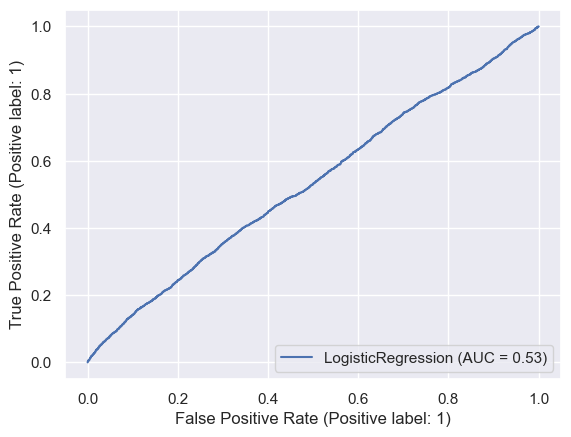

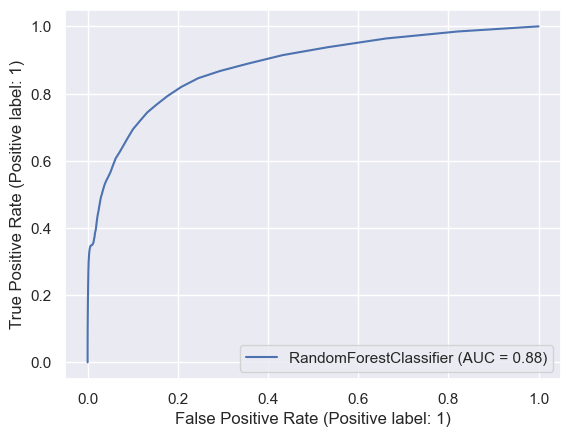

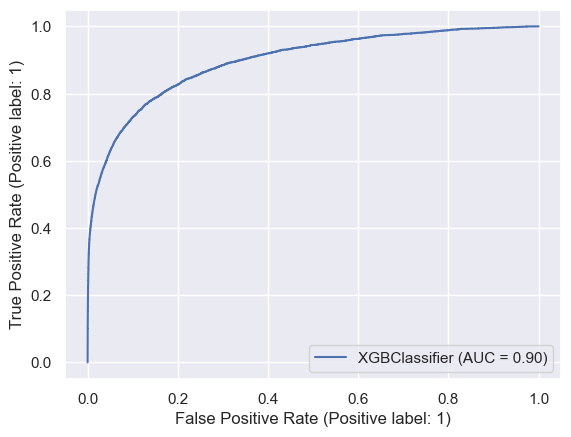

In [ ]:
model_scores = fit_and_score(models=models,
                             X_train=x_train,
                             X_test=x_test,
                             y_train=y_train,
                             y_test=y_test)


In [ ]:
model_scores[0]


{'Logistic Regression': 0.9654553459545501,
 'Random Forest': 0.9735970467707522,
 'Xgboost': 0.9743150336979713}

In [ ]:
model_scores[1]


{'Logistic Regression': None, 'Random Forest': None, 'Xgboost': None}

## base models scaled and class imbalance smooth


In [11]:
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))


[(0, 427342), (1, 427342)]


              precision    recall  f1-score   support

           0       0.99      0.69      0.82    142535
           1       0.08      0.78      0.15      5100

    accuracy                           0.70    147635
   macro avg       0.54      0.73      0.48    147635
weighted avg       0.96      0.70      0.79    147635

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142535
           1       0.84      0.26      0.39      5100

    accuracy                           0.97    147635
   macro avg       0.91      0.63      0.69    147635
weighted avg       0.97      0.97      0.97    147635

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    142535
           1       0.39      0.55      0.45      5100

    accuracy                           0.95    147635
   macro avg       0.68      0.76      0.71    147635
weighted avg       0.96      0.95      0.96    147635



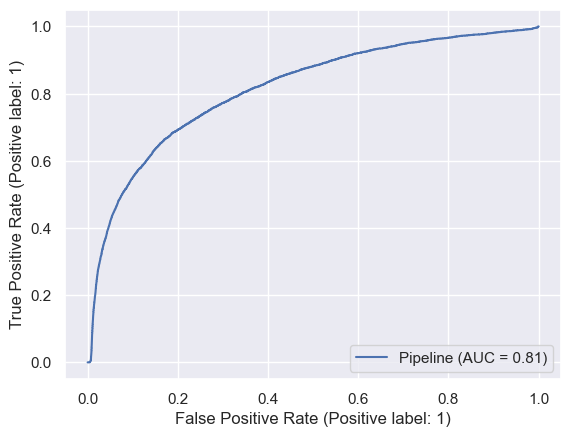

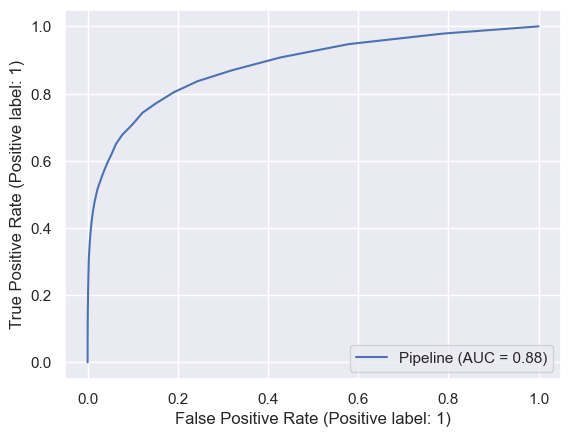

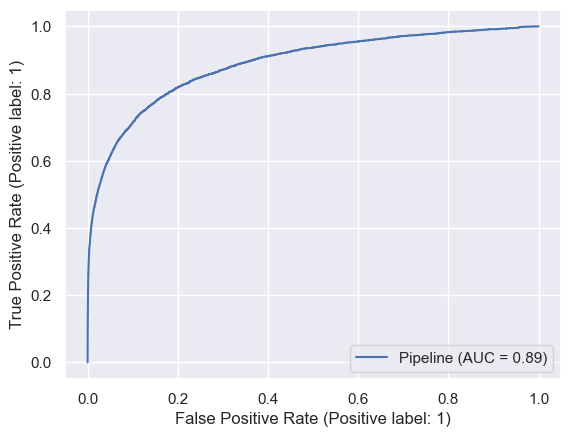

In [ ]:
model = fit_and_score_scaled(X_train=X_resampled,
                             X_test=x_test,
                             y_train=y_resampled,
                             y_test=y_test,
                             models=models)


In [ ]:
model[0]


{'Logistic Regression': 0.697456565177634,
 'Random Forest': 0.972628441765164,
 'Xgboost': 0.954136891658482}

## Neural network base model


In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(
    10, 5), max_iter=100, activation='relu', solver='adam', random_state=1)
NN_base = classifier.fit(x_train, y_train)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    142535
           1       0.00      0.00      0.00      5100

    accuracy                           0.97    147635
   macro avg       0.48      0.50      0.49    147635
weighted avg       0.93      0.97      0.95    147635



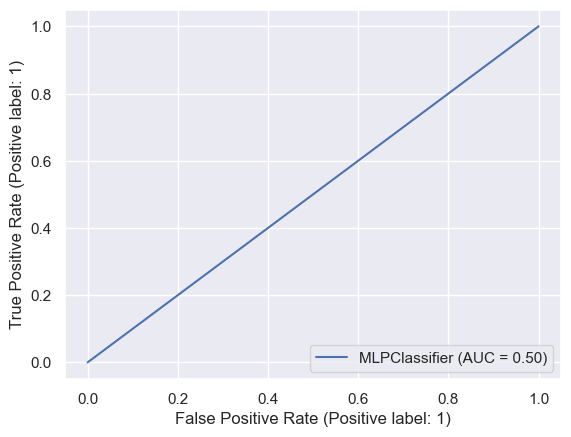

In [ ]:
# Make preidctions on test data
y_preds = NN_base.predict(x_test)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(NN_base, x_test, y_test)
# Show classification report
print(classification_report(y_test, y_preds))


In [ ]:
y_train_pred = NN_base.predict(x_train)
y_test_pred = NN_base.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, NN_base.predict_proba(x_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(
    y_test, NN_base.predict_proba(x_test)[:, 1])

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.5
Area under test roc 0.5


## Neural network with scaled data


In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(
        10, 5), max_iter=100, activation='relu', solver='adam', random_state=1)
)
# Fit the model to the data
pipe.fit(x_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=100,
                               random_state=1))])

In [ ]:

y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, pipe.predict_proba(x_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(
    y_test, pipe.predict_proba(x_test)[:, 1])

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.9007193243813114
Area under test roc 0.8334807728683082


              precision    recall  f1-score   support

           0       0.98      0.99      0.98    142535
           1       0.54      0.29      0.38      5100

    accuracy                           0.97    147635
   macro avg       0.76      0.64      0.68    147635
weighted avg       0.96      0.97      0.96    147635



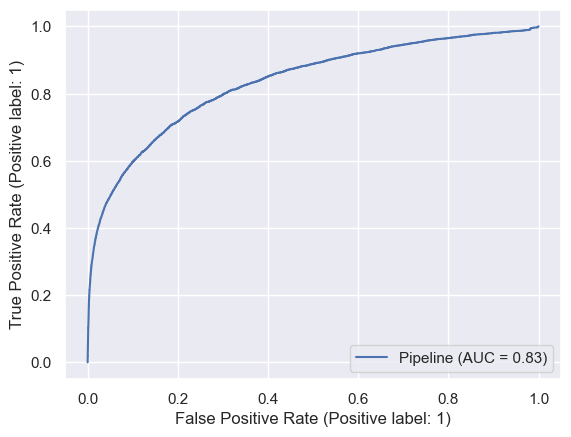

In [ ]:
# Make preidctions on test data
y_preds = pipe.predict(x_test)
# Plot ROC curve and calculate AUC metric
plot_roc_curve(pipe, x_test, y_test)
# Show classification report
print(classification_report(y_test, y_preds))


## neural Network with scaled and oversmapling class imbalance


In [ ]:
pipe2 = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(
        10, 5), max_iter=100, activation='relu', solver='adam', random_state=1)
)
# Fit the model to the data
pipe2.fit(X_resampled, y_resampled)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=100,
                               random_state=1))])

Area under train roc 0.9252230597828551
Area under test roc 0.8280278493689543


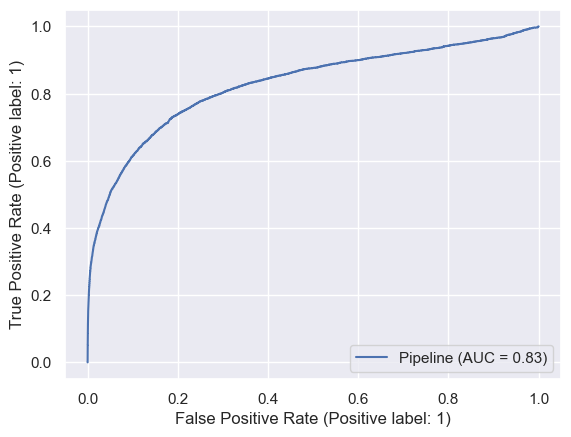

In [ ]:
y_train_pred = pipe2.predict(x_train)
y_test_pred = pipe2.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, pipe2.predict_proba(x_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(
    y_test, pipe2.predict_proba(x_test)[:, 1])

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
# Plot ROC curve and calculate AUC metric
plot_roc_curve(pipe2, x_test, y_test)


In [12]:
def plot_confusion_matrix(data, preds, title):
    conf = confusion_matrix(data, preds)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt="0")
    plt.title(title)
    plt.show()


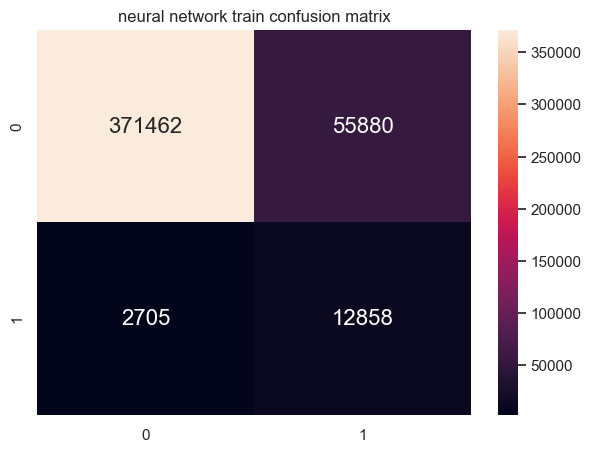

In [ ]:
plot_confusion_matrix(y_train, y_train_pred,
                      'neural network train confusion matrix')


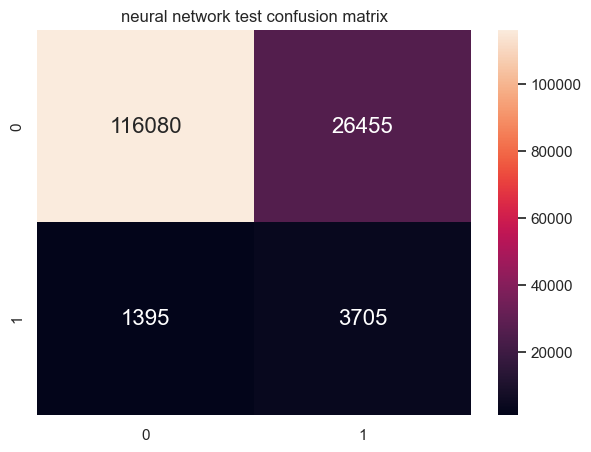

In [ ]:
plot_confusion_matrix(y_test, y_test_pred,
                      'neural network test confusion matrix')


## XGBoost random search and oversampling


In [15]:
params = {'n_estimators': [500, 1000, 1500, 2000, 2500],
          'max_depth': [3, 6, 12, 24], 'subsample': [0.2, 0.4, 0.6, 0.8], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

clf = xgb.XGBClassifier(
        eval_metric='auc', tree_method='gpu_hist')


model = RandomizedSearchCV(estimator=clf, param_distributions=params,
                           scoring='roc_auc', verbose=1, cv=5, n_iter=10)
model.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [3, 6, 12, 24],
                                        'n_estimators': [500, 1000, 1500, 2000,
                                                         2500],
                                        'subsample': [0.2, 0.4, 0.6, 0.8]},
                   scoring='roc_auc', verbose=1)

In [16]:
model.best_params_

{'subsample': 0.4, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.2}

In [17]:
model = xgb.XGBClassifier(random_state = 100, **model.best_params_
    )
model.fit(X_resampled, y_resampled)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model.predict_proba(x_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(
    y_test, model.predict_proba(x_test)[:, 1])

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.9999999999999999
Area under test roc 0.9060882026224037


In [30]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.42      0.55      5100

    accuracy                           0.98    147635
   macro avg       0.89      0.71      0.77    147635
weighted avg       0.97      0.98      0.97    147635



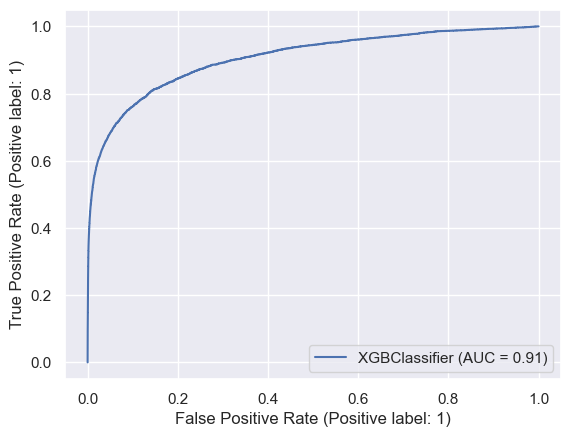

In [18]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(model, x_test, y_test)

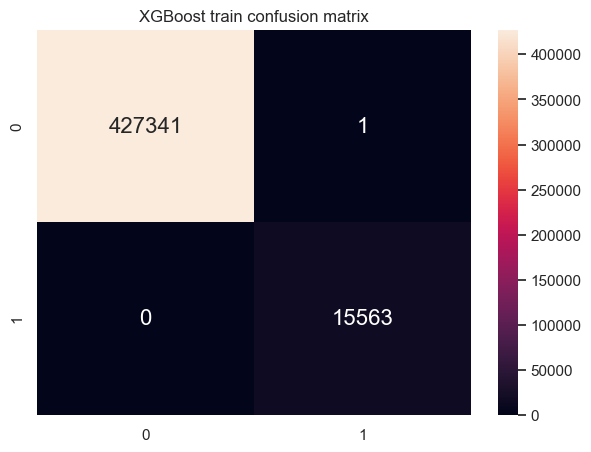

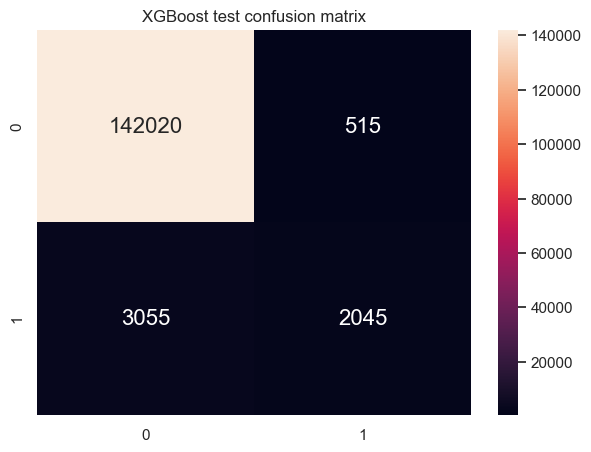

In [19]:
plot_confusion_matrix(y_train, y_train_pred, 'XGBoost train confusion matrix')
plot_confusion_matrix(y_test, y_test_pred, 'XGBoost test confusion matrix')


In [20]:
def plot_feature_importance(model):
    fig, axes = plt.subplots(figsize=(20, 20))
    plot_importance(model, max_num_features=50, height=0.5, ax=axes)
    plt.show()

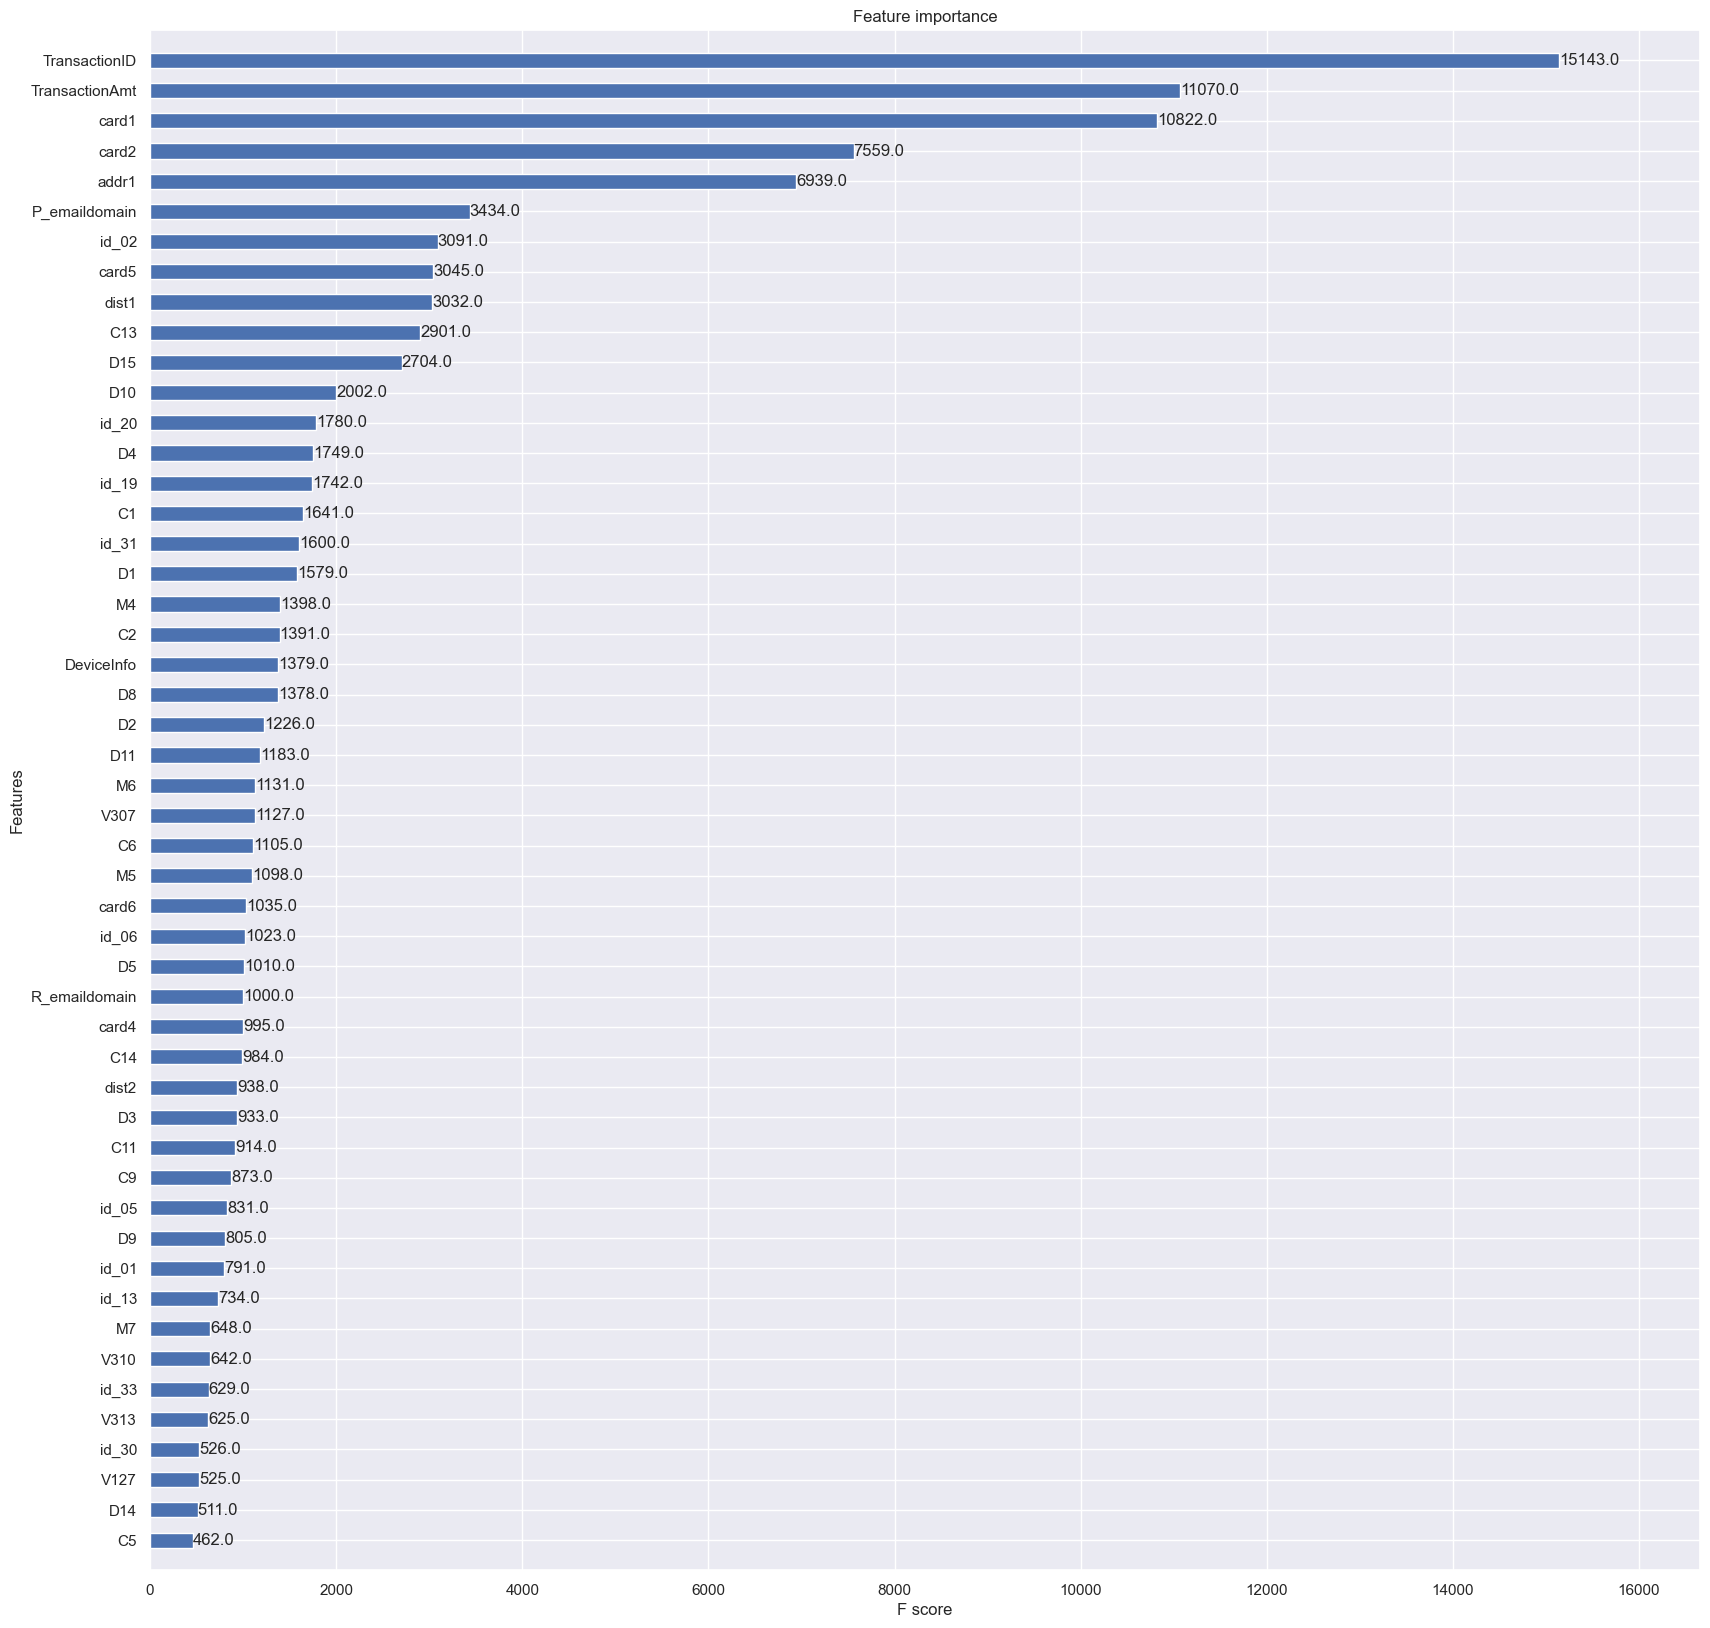

In [21]:
plot_feature_importance(model=model)


In [25]:
params = {'n_estimators':[1000,2000],'max_depth':[3,6,12],'subsample':[0.4,0.8]}

clf = xgb.XGBClassifier(learning_rate=0.2,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4)


GS_model = GridSearchCV(clf, params, scoring='roc_auc', verbose=1, cv=5)
GS_model.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.4,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [3, 6, 12], 'n_estimators': [1000, 2000],
                         'subsample': [0.4, 0.8]},
             scoring='roc_auc', verbose=1)

In [26]:
GS_model.best_params_

{'max_depth': 12, 'n_estimators': 2000, 'subsample': 0.8}

In [31]:
model2 = xgb.XGBClassifier(random_state = 100, **GS_model.best_params_,
    eval_metric='auc', tree_method='gpu_hist')
model2.fit(X_resampled, y_resampled)
y_train_pred = model2.predict(x_train)
y_test_pred = model2.predict(x_test)

train_fpr, train_tpr, thresholds = roc_curve(
    y_train, model2.predict_proba(x_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(
    y_test, model2.predict_proba(x_test)[:, 1])
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.9999999999999999
Area under test roc 0.8988881169193395


In [32]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142535
           1       0.80      0.42      0.55      5100

    accuracy                           0.98    147635
   macro avg       0.89      0.71      0.77    147635
weighted avg       0.97      0.98      0.97    147635



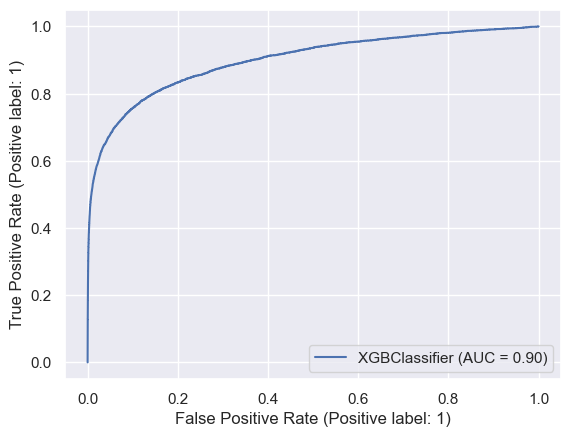

In [33]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(model2, x_test, y_test)


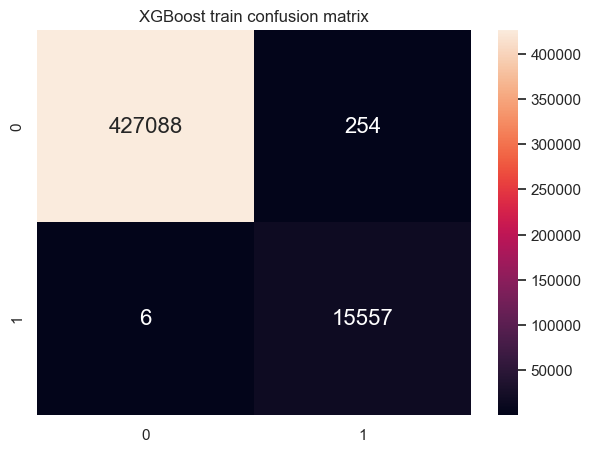

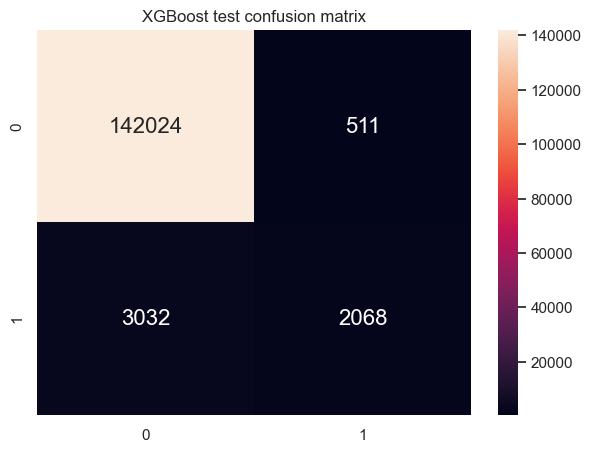

In [ ]:
plot_confusion_matrix(y_train, y_train_pred, 'XGBoost train confusion matrix')
plot_confusion_matrix(y_test, y_test_pred, 'XGBoost test confusion matrix')


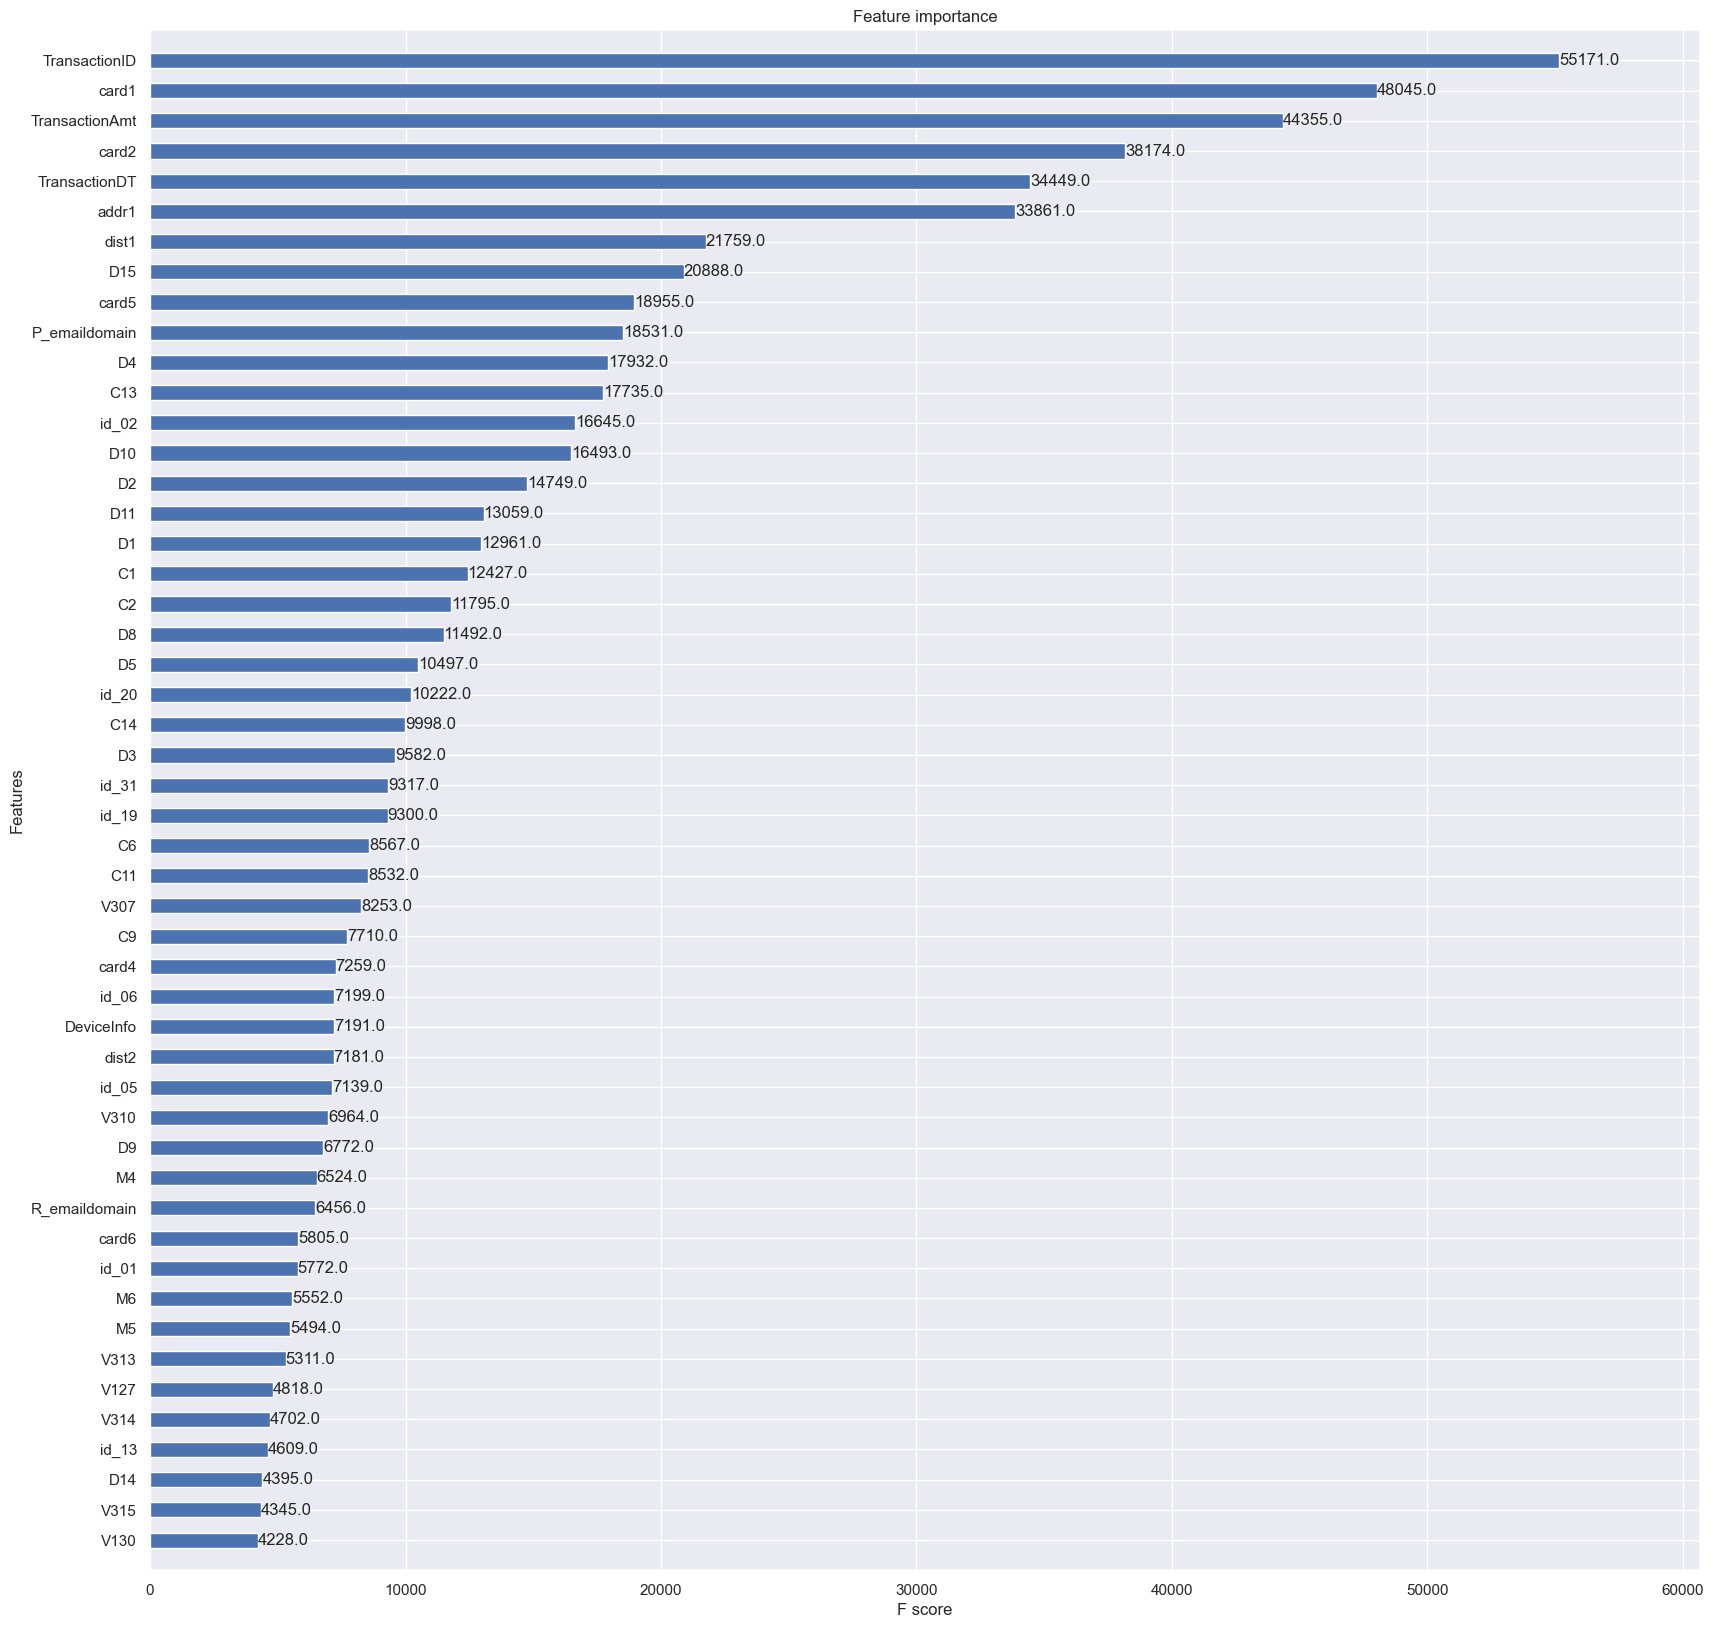

In [ ]:
plot_feature_importance(model=model2)


## LGBM model trained with optuna


In [ ]:
def opt_plot(study, plot):
    if plot == 0:
        return optvis.plot_optimization_history(study)
    if plot == 1:
        return optvis.plot_slice(study)
    if plot == 2:
        return optvis.plot_parallel_coordinate(study)
    if plot == 3:
        return optvis.plot_contour(study)
    if plot == 4:
        return optvis.plot_param_importances(study)


In [ ]:
% % time


def lgbm_objective(trial):

    n = trial.suggest_int('n_estimators', 20, 150)
    md = trial.suggest_int('max_depth', 2, 40)
    nl = trial.suggest_int('num_leaves', 50, 500)
    lr = trial.suggest_float('learning_rate', 0, 1, log=False)
    ss = trial.suggest_float('subsample', 0.6, 1, log=False)
    nj = trial.suggest_int('n_jobs', 1, 4)
    bt = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])

    clf = LGBMClassifier(n_estimators=n, max_depth=md, learning_rate=lr, boosting_type=bt, num_leaves=nl, n_jobs=nj,
                         subsample=ss, random_state=1)

    scores = cross_val_score(clf, x_train, y_train,
                             n_jobs=-1, cv=5, scoring='roc_auc')
    return scores.mean()


lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=20)

print()
print(lgbm_study.best_value)
print(lgbm_study.best_params)


[I 2022-12-01 23:09:05,641] A new study created in memory with name: no-name-44ac5b76-d450-49e1-a9dd-36b6b2ba5631
[I 2022-12-01 23:10:55,190] Trial 0 finished with value: 0.8511366271278415 and parameters: {'n_estimators': 68, 'max_depth': 21, 'num_leaves': 285, 'learning_rate': 0.038093858264667935, 'subsample': 0.6140866769345151, 'n_jobs': 1, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.8511366271278415.
[I 2022-12-01 23:11:51,631] Trial 1 finished with value: 0.6746743842032925 and parameters: {'n_estimators': 57, 'max_depth': 12, 'num_leaves': 62, 'learning_rate': 0.6390999307741053, 'subsample': 0.9409391601634373, 'n_jobs': 2, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.8511366271278415.
[I 2022-12-01 23:13:08,827] Trial 2 finished with value: 0.8195063746034951 and parameters: {'n_estimators': 55, 'max_depth': 30, 'num_leaves': 177, 'learning_rate': 0.060510330281676294, 'subsample': 0.735836332915155, 'n_jobs': 1, 'boosting_type': 'gbdt'}. Best is trial 


0.8511366271278415
{'n_estimators': 68, 'max_depth': 21, 'num_leaves': 285, 'learning_rate': 0.038093858264667935, 'subsample': 0.6140866769345151, 'n_jobs': 1, 'boosting_type': 'dart'}
CPU times: total: 6.5 s
Wall time: 26min 29s


In [ ]:
opt_plot(lgbm_study, plot=0)


In [ ]:
opt_plot(lgbm_study, plot=1)


In [ ]:
opt_plot(lgbm_study, plot=2)


In [ ]:
opt_plot(lgbm_study, plot=3)


In [ ]:
opt_plot(lgbm_study, plot=4)


In [ ]:
final_model = LGBMClassifier(random_state=1, **lgbm_study.best_params)
final_model.fit(x_train, y_train)

print(final_model.score(x_test, y_test))


0.973041622921394


In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(
    y_train, final_model.predict_proba(x_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(
    y_test, final_model.predict_proba(x_test)[:, 1])
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


Area under train roc 0.9157692676405227
Area under test roc 0.8728026958634859


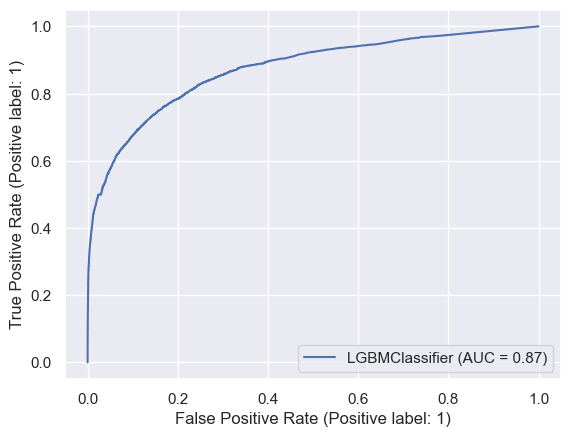

In [ ]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(final_model, x_test, y_test)


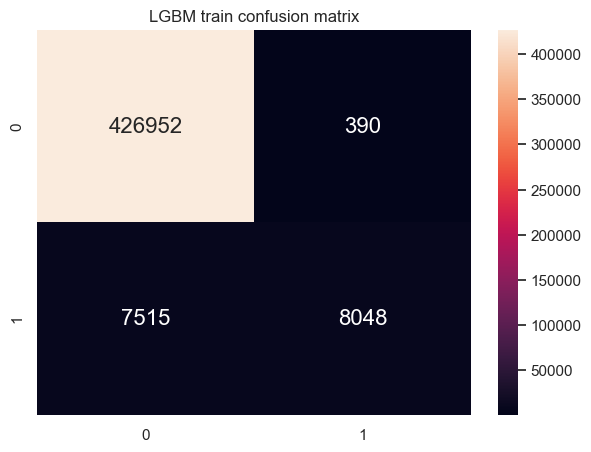

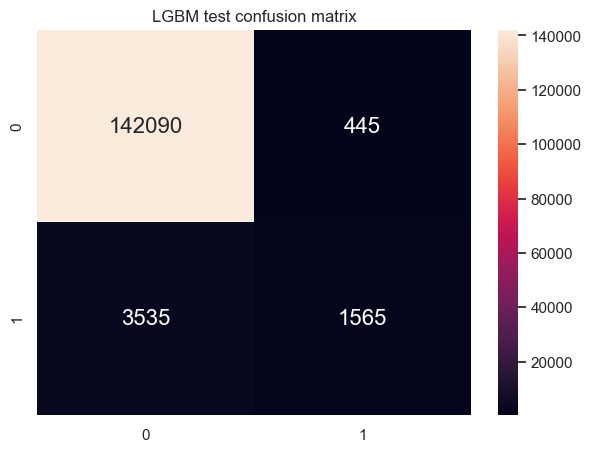

In [ ]:
y_train_pred = final_model.predict(x_train)
y_test_pred = final_model.predict(x_test)
plot_confusion_matrix(y_train, y_train_pred, 'LGBM train confusion matrix')
plot_confusion_matrix(y_test, y_test_pred, 'LGBM test confusion matrix')


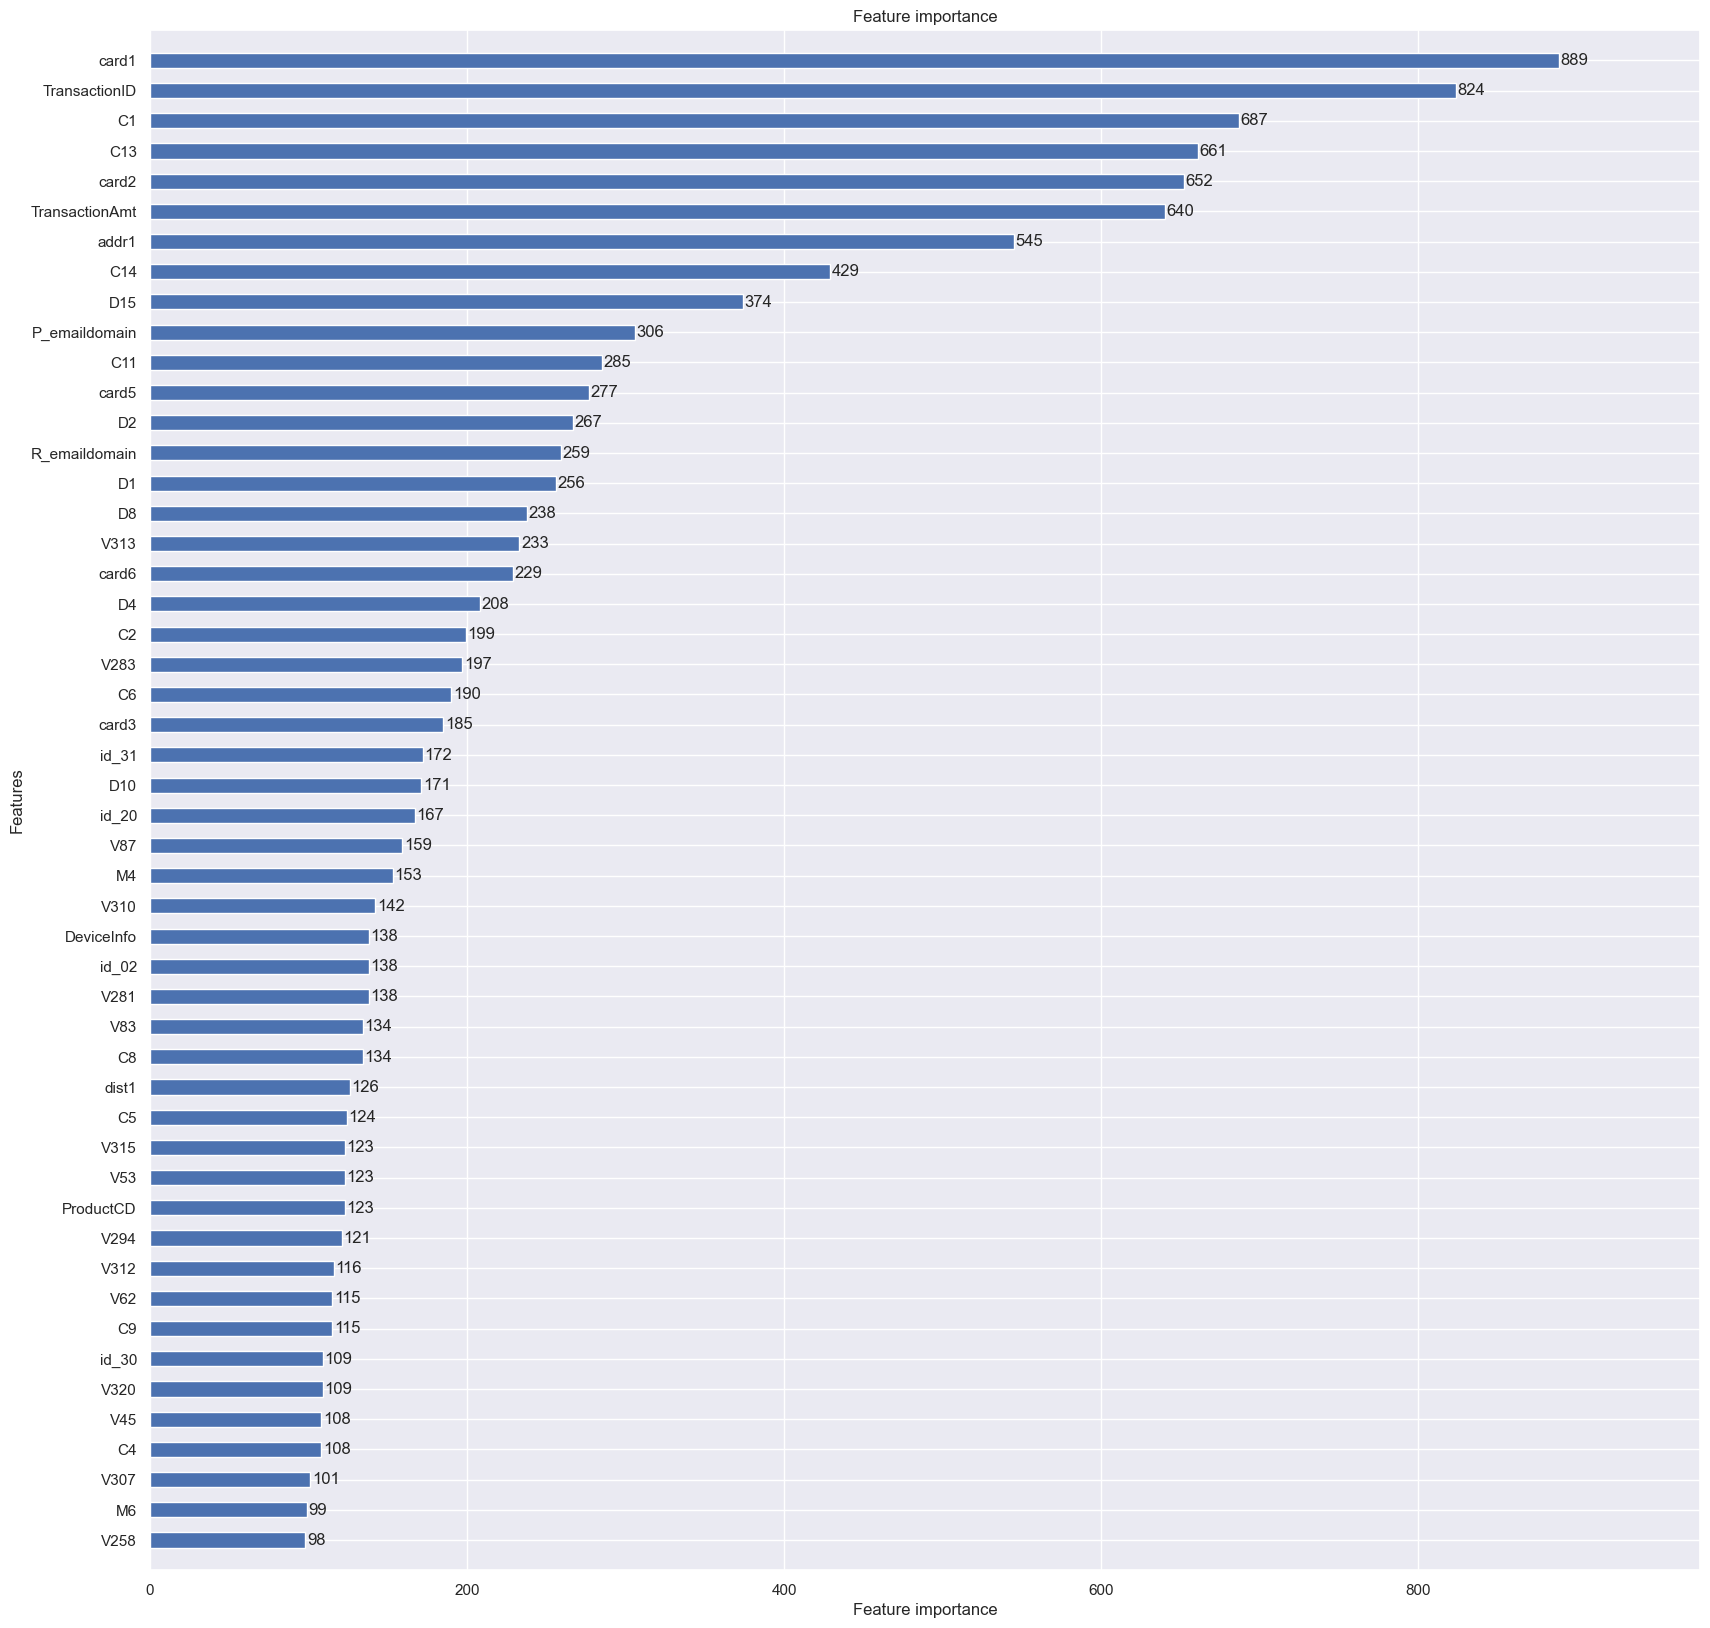

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
plot_importance(final_model, max_num_features=50, height=0.5, ax=axes)
plt.show()


## Adding more features and using XGBoost to perform feature selection usinf FFS (forward feature selection)


### Normalizing D cols


In [ ]:
df_train = pd.read_csv('../Data/train_combined.csv')
df_test = pd.read_csv('../Data/test_combined.csv')


In [ ]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


Mem. usage decreased to 706.79 Mb (63.9% reduction)
Mem. usage decreased to 613.69 Mb (63.3% reduction)


In [ ]:
# column details
cat_cols = (['ProductCD'] +
            ['card%d' % i for i in range(1, 7)] +
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] +
            ['M%d' % i for i in range(1, 10)] +
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols = [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39',
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67',
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81',
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95',
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108',
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120',
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132',
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144',
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156',
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168',
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180',
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192',
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204',
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216',
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228',
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240',
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252',
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264',
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288',
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300',
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312',
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324',
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336',
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
    'id_09', 'id_10', 'id_11'
]

v_cols_included = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20',
                   'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59',
                   'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96',
                   'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127',
                   'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
                   'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185',
                   'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258',
                   'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234',
                   'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
                   'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']


In [ ]:
# droping v cols
drop_cols = [col for col in df_train.columns if col[0]
             == 'V' and col not in v_cols_included]

print(f'dropping {len(drop_cols)} columns')
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)


dropping 211 columns


In [ ]:
# Train and test split¶
y_train = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()


(590540, 222)
(506691, 222)


667

In [ ]:
# Label encoding all cat features
for col in X_train.columns:

    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col], X_test[col]])
        dff, _ = pd.factorize(dff, sort=True)
        if dff.max() > 32000:
            print(col, 'needs int32 datatype')

        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')


In [ ]:
norm_cols = [15, 4, 2, 11, 10]
# NORMALIZE D COLUMNS
for i in range(1, 16):
    if i in norm_cols:
        X_train['D'+str(i)+'n'] = X_train['D'+str(i)] - \
            X_train.TransactionDT/np.float32(24*60*60)
        X_test['D'+str(i)+'n'] = X_test['D'+str(i)] - \
            X_test.TransactionDT/np.float32(24*60*60)


In [ ]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] -
                    np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] -
                   np.floor(X_test['TransactionAmt'])).astype('float32')


In [ ]:
def process_DeviceInfo(df):
    df['DeviceCorp'] = df['DeviceInfo']
    df.loc[df['DeviceInfo'].str.contains(
        'HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    df.loc[df['DeviceInfo'].str.contains(
        'OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    df.loc[df['DeviceInfo'].str.contains(
        'Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    df.loc[df['DeviceInfo'].str.contains(
        'Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    df.loc[df['DeviceInfo'].str.contains(
        'MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    df.loc[df['DeviceInfo'].str.contains(
        'VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    df.loc[df['DeviceInfo'].str.contains(
        'ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    df.loc[df['DeviceInfo'].str.contains(
        'ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    df.loc[df['DeviceInfo'].str.contains(
        'OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    df.loc[df['DeviceInfo'].str.contains(
        'Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    df.loc[df['DeviceInfo'].str.contains(
        'STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    df.loc[df['DeviceInfo'].str.contains(
        'ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    df.loc[df['DeviceInfo'].str.contains(
        'BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'

    df['DeviceCorp'] = df['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
        str.split('-', expand=True)[0].str.split(expand=True)[0]

    df.loc[df['DeviceInfo'].isin(
        ['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    df.loc[df['DeviceInfo'].str.startswith(
        'Z', na=False), 'DeviceCorp'] = 'ZTE'
    df.loc[df['DeviceInfo'].str.startswith(
        'KF', na=False), 'DeviceCorp'] = 'Amazon'

    for i in ['D', 'E', 'F', 'G']:
        df.loc[df['DeviceInfo'].str.startswith(
            i, na=False), 'DeviceCorp'] = 'SONY'
    df.loc[df['DeviceCorp'].isin(df['DeviceCorp'].value_counts()
                                 [df['DeviceCorp'].value_counts() < 100].index), 'DeviceCorp'] = 'Other'
    df['DeviceCorp'] = df['DeviceCorp'].str.upper()

    return df


df_train = process_DeviceInfo(df_train)
df_test = process_DeviceInfo(df_test)
X_train['DeviceCorp'] = df_train['DeviceCorp']
X_test['DeviceCorp'] = df_test['DeviceCorp']


In [ ]:
email_dict = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
              'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com':
              'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
              'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
              'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
              'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft',
              'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other',
              'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
              'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink',
              'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo',
              'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft',
              'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink',
              'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com':
              'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com':
              'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol',
              'juno.com': 'other', 'icloud.com': 'apple'}


X_train['P_email_company'] = df_train['P_emaildomain'].map(email_dict)
X_test['P_email_company'] = df_test['P_emaildomain'].map(email_dict)


In [ ]:
# Transaction Date
X_train['dayofweek'] = (X_train['TransactionDT']//(60*60*24)-1) % 7
X_test['dayofweek'] = (X_train['TransactionDT']//(60*60*24)-1) % 7

X_train['hour'] = (X_train['TransactionDT']//(60*60)) % 24
X_test['hour'] = (X_test['TransactionDT']//(60*60)) % 24


X_train['logTransactionAmt'] = np.log1p(X_train['TransactionAmt'])
X_test['logTransactionAmt'] = np.log1p(X_test['TransactionAmt'])


In [ ]:
# hour fraud status
def fraud_hour_map(hour):

    hour_fraud_dict = {
        'high': [6, 7, 8, 9],
        'very_low': [13, 14, 15],
        'medium': [3, 4, 5, 10],
        'low': [0, 1, 2, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23]
    }

    for k, v in hour_fraud_dict.items():
        if int(hour) in v:
            return k


X_train['hour_fraud_status'] = X_train['hour'].apply(
    lambda x: fraud_hour_map(x))
X_test['hour_fraud_status'] = X_test['hour'].apply(lambda x: fraud_hour_map(x))


In [ ]:
rem_cols = []
rem_cols.extend(['TransactionDT', 'TransactionID'])

norm_cols = [15, 4, 2, 11, 10]
rem_cols.extend(['D'+str(i) for i in norm_cols])

for c in ['day', 'uid']:
    if c not in rem_cols:
        rem_cols.append(c)

new_feats = ['dayofweek', 'hour', 'P_email_company', 'DeviceCorp',
             'cents', 'logTransactionAmt', 'hour_fraud_status']

cols = [col for col in X_train.columns if col not in rem_cols and col not in new_feats]


In [ ]:
# encoding cat features

new_cat_cols = ['DeviceCorp', 'P_email_company', 'hour_fraud_status']

for col in new_cat_cols:
    dff = pd.concat([X_train[col], X_test[col]])
    dff, _ = pd.factorize(dff, sort=True)
    if dff.max() > 32000:
        print(col, 'needs int32 datatype')

    X_train[col] = dff[:len(X_train)].astype('int16')
    X_test[col] = dff[len(X_train):].astype('int16')


In [ ]:

# Scaling numeric features
for col in X_train.columns:
    if col not in cat_cols and col not in new_cat_cols and col not in rem_cols:
        # min max scalar
        dff = pd.concat([X_train[col], X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1, inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff


In [ ]:
def model(x_train, y_train, cols):
    idx_train = x_train.index[:int(x_train.shape[0]*0.75)]
    idx_validation = x_train.index[int(x_train.shape[0]*0.75):]

    print(f'fitting model on {len(cols)} columns')
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        tree_method='gpu_hist'
    )
    model = clf.fit(x_train.loc[idx_train, cols], y_train[idx_train],
                    eval_set=[(x_train.loc[idx_validation, cols],
                               y_train[idx_validation])],
                    verbose=50, early_stopping_rounds=100)
    del clf
    return model.best_score


def forward_feat_selection(new_cols, old_cols, best_score):
    print(
        f'Forward feature selection on {len(new_cols)} features <-->  current best score {best_score} with {len(old_cols)} features')
    iteration = 1
    iteration_best_col = None
    # list of additional columns
    best_cols = []
    while iteration <= len(new_cols):
        for j, col in enumerate(new_cols):
            print(f'Model no: {iteration}_{(j+1)}')
            print('--'*40)
            if col not in best_cols:
                current_cols = old_cols.copy()
                # adding new feature
                best_cols.append(col)
                print(f'Adding new features: {best_cols}')
                current_cols.extend([c for c in best_cols])
                current_score = model(X_train, y_train, current_cols)

                if current_score > best_score:
                    print(
                        f'Score improved on adding {col} new best score {current_score}')
                    iteration_best_col = col
                    best_score = current_score
                else:
                    print(f'Score not improved on adding {col}')

                best_cols.remove(col)

            else:
                print(f'Skipping {col} already an selected column')

            print('--'*40)

        # end of 1 iteration we add best column
        iteration += 1
        if iteration_best_col is not None:
            best_cols.append(iteration_best_col)
            print(
                f'Best col in this iteration {iteration_best_col}, --->   current best cols: {best_cols}')
            iteration_best_col = None

        else:
            print('None of the columns improving the score in this iteration')
            print('###'*40)
            break

        print('###'*40)

    print(f'Useful new features : {best_cols}')
    print(f'Best score : {best_score}')


In [ ]:
forward_feat_selection(new_cols=new_feats, old_cols=cols, best_score=0.9327)


Forward feature selection on 7 features <-->  current best score 0.9327 with 220 features
Model no: 1_1
--------------------------------------------------------------------------------
Adding new features: ['dayofweek']
fitting model on 221 columns
[0]	validation_0-auc:0.82988
[50]	validation_0-auc:0.86973
[100]	validation_0-auc:0.88656
[150]	validation_0-auc:0.89879
[200]	validation_0-auc:0.90973
[250]	validation_0-auc:0.91739
[300]	validation_0-auc:0.92323
[350]	validation_0-auc:0.92746
[400]	validation_0-auc:0.93008
[450]	validation_0-auc:0.93156
[500]	validation_0-auc:0.93231
[550]	validation_0-auc:0.93321
[600]	validation_0-auc:0.93304
[650]	validation_0-auc:0.93324
[661]	validation_0-auc:0.93321
Score improved on adding dayofweek new best score 0.9333182548214852
--------------------------------------------------------------------------------
Model no: 1_2
--------------------------------------------------------------------------------
Adding new features: ['hour']
fitting model 